Импортируем нужные библиотеки.

In [1]:
import torch
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from torch.nn import CTCLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchmetrics import CharErrorRate
from ctc_decoder import beam_search

from dataset import CaptchaDataset
from models import Net

Далее инициализируем список токенов буквами английского алфавита и арабскими цифрами + blank (пустой) токен. Будем предполагать, что только они могут встречаться в капчах.  
Также сделаем словари для перевода токена в индекс и наоборот.

In [2]:
ALPHABET = "a b c d e f g h i j k l m n o p q r s t u v w x y z"
DIGITS = "1 2 3 4 5 6 7 8 9 0"

tokens = [".", *(ALPHABET.split(" ")), *(DIGITS.split(" "))]
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

Далее создадим даталоудеры для тренировочного и тестового наборов.  
Датасет из себя представляем набор пар: картинка (в RGB) и набор из пяти токенов (буква или цифра).  
В качестве препоцессинга используем нормализацию изображений со значениями mean и std из ImageNet, перевод картинки в тензор. Токены переведем в индексы, а их - в тензор.

In [3]:
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])
target_transform = transforms.Compose([
    lambda target_str: [token_to_idx[ch] for ch in target_str],
    torch.Tensor
])

trainset = CaptchaDataset(
    is_train=True,
    transform=transform,
    target_transform=target_transform
)
testset = CaptchaDataset(
    is_train=False,
    transform=transform,
    target_transform=target_transform
)

batch_size = 64
current_cpu_count = multiprocessing.cpu_count()
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=current_cpu_count)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=current_cpu_count)

Тут просто визуализация данных.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


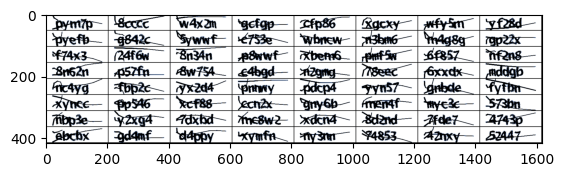

['pym7p', '8cccc', 'w4x2m', 'gcfgp', 'cfp86', 'xgcxy', 'wfy5m', 'yf28d', 'pyefb', 'g842c', '5ywwf', 'c753e', 'wbncw', 'n3bm6', 'm4g8g', 'gp22x', 'f74x3', '24f6w', '8n34n', 'p8wwf', 'xbem6', 'pmf5w', '6f857', 'nf2n8', '8n62n', 'p57fn', '8w754', 'c4bgd', 'n2gmg', '78eec', '6xxdx', 'mddgb', 'nc4yg', 'fbp2c', 'yx2d4', 'pnnwy', 'pdcp4', 'yyn57', 'gnbde', 'fyfbn', 'xyncc', 'pp546', 'xcf88', 'ccn2x', 'gny6b', 'men4f', 'myc3c', '573bn', 'nbp3e', 'y2xg4', '7dxbd', 'mc8w2', 'xdcn4', '8d2nd', '7fde7', '4743p', 'ebcbx', 'gd4mf', 'd4ppy', 'xymfn', 'ny3nn', '74853', '42nxy', '52447']


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

letters_labels = []
for label in labels:
    letters_labels.append("".join([idx_to_token[idx.item()] for idx in label]))
    
print(letters_labels)

Надеюсь, у вас есть cuda :)

In [5]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

Создадим инстанс класса нашей сети. Архитектуру можно глянуть в файлике models.py.  
В целом все стандартно: CNN, LSTM, FC. Немного reshape и permute, чтобы подружить свертку и рекуррентку.

In [6]:
net = Net(len(tokens)).to(device)

Рутина обучения, тут все тоже стандартно. CTCLoss считается ровно как в [примере из доки](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html).

In [7]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    loss_history = []
    for epoch in range(num_epochs):
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            pred = net(inputs.to(device))
            pred = pred.permute(1, 0, 2)
            
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=pred.shape[0], dtype=torch.long)
            target_lengths = torch.full(size=(inputs.shape[0],), fill_value=labels.shape[1], dtype=torch.long)
            
            loss = criterion(pred.log_softmax(-1), labels, input_lengths, target_lengths)
            loss_history.append(loss.item())
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()

        if epoch % 10 == 9:
            print(f"Epoch: {epoch + 1}, current_loss: {loss.item()}, mean loss through the history: {sum(loss_history) / len(loss_history)}")

    print('Finished Training')
    
    return net

Отпимизатор - Адам. Лосс - CTCLoss.

In [8]:
optimizer = Adam(net.parameters())
criterion = CTCLoss()

Треним много эпох, я рил надеюсь, что у вас есть gpu :)

In [9]:
net = train_model(net, criterion, optimizer, trainloader, 200)

Epoch: 10, current_loss: 0.10615578293800354, mean loss: 1.5490680020589096
Epoch: 20, current_loss: 0.06557106971740723, mean loss: 0.8021356434919513
Epoch: 30, current_loss: 0.05457567423582077, mean loss: 0.5447981963495317
Epoch: 40, current_loss: 0.04933542385697365, mean loss: 0.4151732836348506
Epoch: 50, current_loss: 0.001814036164432764, mean loss: 0.33434015258125815
Epoch: 60, current_loss: 0.0005834319163113832, mean loss: 0.27888834794322087
Epoch: 70, current_loss: 0.00039704289520159364, mean loss: 0.23912341695088268
Epoch: 80, current_loss: 0.00026999422698281705, mean loss: 0.20927482690318497
Epoch: 90, current_loss: 0.00023377855541184545, mean loss: 0.18605137589606746
Epoch: 100, current_loss: 0.00021839194232597947, mean loss: 0.16746789144073354
Epoch: 110, current_loss: 0.00016271938511636108, mean loss: 0.15225995589833066
Epoch: 120, current_loss: 0.00013828324154019356, mean loss: 0.1395848533193389
Epoch: 130, current_loss: 0.000126280210679397, mean loss

Ну и наконец CharErrorRate.

In [10]:
char_error_rate = CharErrorRate()
char_error_rate_history = []
with torch.no_grad():
    for inputs, labels in testloader:
        labels = labels.to(device)
        
        pred_probs = net(inputs.to(device)).softmax(-1)
        
        labels_pred = []
        for batch_item in pred_probs:
            letters_pred = []
            for probs in batch_item.cpu():
                letters_pred.append([*[item.item() for item in probs[1:]], probs[:1].item()])
            labels_pred.append(beam_search(np.array([np.array(xi) for xi in letters_pred]), tokens[1:]))
        
        labels_real = []
        for label in labels:
            labels_real.append("".join([idx_to_token[item.item()] for item in label]))
        
        char_error_rate_history.append(char_error_rate(labels_real, labels_pred).item())

print(f"Char Error Rates on test data: {char_error_rate_history}")
print(f"Mean Char Error Rate on test data: {sum(char_error_rate_history) / len(char_error_rate_history)}")

Char Error Rates on test data: [0.035256411880254745, 0.032258063554763794, 0.012618296779692173, 0.02500000037252903]
Mean Char Error Rate on test data: 0.026283193146809936


В среднем ошибаемся в <5% случаях, что считаю вполне неплохим результатом.